# Neural Network - MNIST

## Өгөгдөл унших

In [1]:
import numpy as np
import mnist
import helper
import math
import random
from matplotlib import pyplot as plt
% matplotlib inline

training_images, training_labels, test_images, test_labels = mnist.load()

def nanCheck(x, msg):
#     print(type(x))
    if type(x) is list or type(x) is np.ndarray:
#         print('--1if')
#         print(type(x[0]))
        if type(x[0]) is list:
#             print('----2if')
            for i, t in enumerate(x):
#                 print('------for')
                if np.isnan(np.array(t, dtype=np.float64)).any():
                    print(x)
                    raise ValueError('NaN ' + str(i) + ': ' + msg)
            return None
        if type(x[0]) is np.ndarray:
#             print('----3if')
            for i, t in enumerate(x):
#                 print('------for')
                if np.isnan(t).any():
                    print(x)
                    raise ValueError('NaN ' + str(i) + ': ' + msg)
            return None
#     print('--out')
#     if type(x) is np.ndarray:
#         if np.isnan(x).any():
#             raise ValueError('NaN ' + str(i) + ': ' + msg)
#             return None
#     else:
    try:
        if np.isnan(np.array(x, dtype=np.float64)).any():
            print(x)
            raise ValueError('NaN: ' + msg)
    except:
        print(x)
        raise ValueError('NaN: ' + msg)


## Тооцоолол хийхэд хэрэг болох функцууд

### RELU

\begin{equation*}
relu(y_i) = \begin{cases} 0, & y_i < 0 \\ y_i, & y_i\geq 0 \end{cases}
\end{equation*}

In [2]:
def relu(y):
    nanCheck(y, 'relu - y')
    y[y <= 0] = 0
    nanCheck(y, 'relu - relu(y)')
    return y

### Softmax

\begin{equation*}
softmax(y_i) = \frac{e^{y_i}}{\sum_{j}e_j}
\end{equation*}


In [3]:
def softmax(y):
#     print(y)
    nanCheck(y, 'softmax - y')
    e = [np.exp(i) for i in y]
    nanCheck(e, 'softmax - e')
    sum_of_e = sum(e)
    nanCheck(sum_of_e, 'softmax - sum_of_e')
    res = [i / sum_of_e for i in e]
    nanCheck(res, 'softmax - res')
    return res

### Нейронуудын утгыг тооцох

- W - тухайн давхаргын weight
- X - өмнөх нейронуудын утга
- b - тухайн давхаргын bias
\begin{equation*}
W X + b
\end{equation*}

In [4]:
def calculate_neuron(x, weight, bias):
    nanCheck(x, 'calculate_neuron - x')
    nanCheck(weight, 'calculate_neuron - weight')
    nanCheck(bias, 'calculate_neuron - bias')
    return x @ weight + bias

### Negative Log Likelihood
Loss бодоход ашиглана.
- Y* - жинхэнэ ангилал
- Y - бодсон ангилал
- n - сургалтын өгөгдлийн тоо
\begin{equation*}
- \sum_{n} \sum_{i} Y_{ni}^* log(Y_{ni})
\end{equation*}

In [5]:
def nll(y, Y):
    sum = 0
    for (yi, Yi) in zip(y, Y):
#         print(yi, Yi)
        l = np.multiply(np.log(yi), Yi)
#         print(np.log(yi))
        nanCheck(l, 'NLL - Log')
        sum = sum + np.sum(l)
        nanCheck(l, 'NLL - Sum')
    return -(sum/len(y))

### Gradient Descent

In [138]:
def sgd(weights, biases, neurons, neurons_activated, prediction, target):
    dW = []
    db = []
    d = [np.subtract(prediction, target)]
#     print('------Z------')
#     print(prediction)
#     print(target)
#     print(dz)
#     print('------ZZZ-----')
    m = len(d)
    nanCheck(d, 'sgd - dz[0]')
    dW.append(np.multiply(1/m, (np.transpose(neurons[1]) @ d[0])))
    nanCheck(dW, 'sgd - dW[0]')
    db.append(np.multiply(1/m, np.sum(d[0], axis=0)))
    nanCheck(db, 'sgd - db[0]')
    d.append(np.multiply(d[0] @ np.transpose(weights[1]), np.heaviside(neurons_activated[1], 1)))
#     print('22222222222222222222222222222222')
#     print(dz[len(dz)-1].shape)
#     print(neurons[0])
#     print((np.transpose(neurons[0]) @ dz[len(dz)-1]))
#     print('33333333333333333333333333333333')
    nanCheck(d, 'sgd - d')
    dW.append(np.multiply(1/m, (np.transpose(neurons[0]) @ d[1])))
    nanCheck(dW, 'sgd - dW[1]')
    db.append(np.multiply(1/m, np.sum(d[1], axis=0)))
    nanCheck(db, 'sgd - db[1]')
#     print(dz[0].shape, dz[0])
#     print(db[0].shape, db[0])
#     print(dz[1].shape, dz[1])
#     print(db[1].shape, db[1])
#     print('-------dW--------')
#     print(dW)
#     print('-------db--------')
#     print(db)
#     print('-------dd--------')
    # for i in range(len(weights)):
    #     weight = temp[len(temp)-1] @ np.transpose(neurons[-i-1])
    #     bias = biases[-i]
    #     dW.append(weight)
    #     db.append(bias)
    #     temp.append(np.transpose(weights[-1]) @ temp[len(temp)-1])
    dW.reverse()
    db.reverse()
    dW += np.multiply(weights, 0.001)
    db += np.multiply(biases, 0.001)
    return dW, db

## Neural Network класс

In [146]:
class NN:
    def __init__(self, classes, layer_neuron_counts=None):
        self.layer_neuron_counts = layer_neuron_counts
        # Ангилалууд
        self.classes = classes
        # Weight & Bias
        self.weights = []
        self.biases = []
        # Activation функц ашиглаагүй үеийн утгуудыг хадгалана
        self.neurons = []
        # Activation функц ашиглаад гарсан утгуудыг хадгалана
        self.neurons_activated = []
        # Loss утгуудыг хадгалах
        self.losses = []

        # Weight болон bias-уудыг санамсаргүйгээр үүсгэх
        if layer_neuron_counts is not None:
            for i in range(1, len(self.layer_neuron_counts)):
                prev_layer_size = self.layer_neuron_counts[i - 1]
                next_layer_size = self.layer_neuron_counts[i]
                self.weights.append(np.random.randn(prev_layer_size, next_layer_size) * 0.1)
                self.biases.append(np.random.randn(next_layer_size) * 0.1)

    def train(self, training_images, training_labels, epoch, batch_size, learning_rate):
        combined = list(zip(training_images, training_labels))
        random.shuffle(combined)
        training_images[:], training_labels[:] = zip(*combined)
        for e in range(1, epoch + 1):
            print('Epoch: ' + str(e))
            batch_count = round(len(training_images) / batch_size)
            losses = []
            for b in range(0, batch_count):
#                 print('-- Batch: ' + str(b))
#                 print('----start----')
#                 print(self.weights)
#                 print(self.biases)
#                 print('-------------')
                # print(b * batch_size, (b + 1) * batch_size)
                minibatch_data = training_images[b * batch_size:(b + 1) * batch_size][:]
#                 print(minibatch_data.shape)
                # print(training_images.shape)
                # print(minibatch_data.shape)
                minibatch_label = training_labels[b * batch_size:(b + 1) * batch_size]
                # print(training_labels.shape)
                # print(minibatch_label.shape)
                # print('---')
                loss = self.batch_process(minibatch_data, minibatch_label, learning_rate)
#                 print('-----end-----')
#                 print(self.weights)
#                 print(self.biases)
#                 print('-------------')
                self.losses.append(loss)
                helper.print_progress(b + 1, batch_count)
#             self.losses.append(sum(losses))
            print('')

    def forward(self, x):
        self.neurons = [x]
        self.neurons_activated = [x]
#         print('')
#         print('###################')
#         [print(str(i) + ', ') for i in self.neurons[0]]
#         print('###################')
#         print('--------------------------------')
#         print(self.weights)
#         print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
#         print(self.biases)
#         print('================================')
        for i, (weights, biases) in enumerate(zip(self.weights, self.biases)):
            self.neurons.append(calculate_neuron(relu(self.neurons_activated[len(self.neurons_activated)-1]), weights, biases))
            nanCheck(self.neurons, 'forward - self.neurons['+ str(i+1) +']')
            if i == len(self.weights) - 1:
                self.neurons_activated.append(softmax(self.neurons[len(self.neurons)-1]))
            else:
                self.neurons_activated.append(relu(self.neurons[len(self.neurons)-1]))
            nanCheck(self.neurons_activated, 'forward - self.neurons_activated['+ str(i+1) +']')
#         print('NEURONS')
#         print(np.array(self.neurons[0]).shape, np.array(self.neurons[1]).shape)
#         print(self.neurons)
#         print('ACTIVATED')
#         print(np.array(self.neurons_activated[0]).shape, np.array(self.neurons_activated[1]).shape)
#         print(self.neurons_activated)
#         print('neurons')
        return self.neurons_activated[len(self.neurons_activated) -1]

    def batch_process(self, train_datas, training_labels, learning_rate):
        nanCheck(self.weights, 'batch_process - self.weights')
        nanCheck(self.biases, 'batch_process - self.biases')
        predicted_labels = self.forward(train_datas)
        nanCheck(predicted_labels, 'batch_process - predicted_labels')
        true_labels = helper.label2vector(self.classes, training_labels)
        loss = nll(predicted_labels, true_labels)
        nanCheck(loss, 'batch_process - loss')
        dW, db = sgd(self.weights, self.biases, self.neurons, self.neurons_activated, predicted_labels, true_labels)
        nanCheck(dW, 'batch_process - dW')
        nanCheck(db, 'batch_process - db')
        # print(np.array(dW).shape)
#         self.weights[0] = np.subtract(self.weights[0], dW[0])
#         self.biases[0] = np.subtract(self.biases[0], db[0])
#         self.weights[1] = np.subtract(self.weights[1], dW[1])
#         self.biases[1] = np.subtract(self.biases[1], db[1])
#         print(self.weights[0])
#         print(self.weights[1])
#         print("weights1")
#         print(self.weights[0].shape)
#         print(self.weights[1].shape)
#         print(dW)
#         print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
# #         print(dW)
# #         [print(dw) for dw in dW[0]]
#         print('######################################')
#         [print(weights) for weights in self.weights]
        temp = self.weights
        self.weights = np.subtract(self.weights, [[d*learning_rate for d in dw] for dw in dW])
#         print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
#         print(self.weights == temp)
#         [print(weights) for weights in self.weights]
#         print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        nanCheck(self.weights, 'batch_process - self.weights - dW')
#         print("weights2")
#         print(self.weights[0].shape)
#         print(self.weights[1].shape)
#         print('biases1')
#         print(self.biases)
        self.biases = np.subtract(self.biases, [[d*learning_rate for d in dB] for dB in db])
        nanCheck(self.biases, 'batch_process - self.biases + db')
#         print('biases2')
#         print(self.biases)
#         print(db)
#         print('-----------')
        return loss


In [150]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
nn = NN(classes, [len(training_images[0]), 32, len(classes)])
# nn.train(training_images, training_labels, 10, 128, 0.001)
# res = nn.forward(training_images[0])
# print(res)
# label = np.zeros(10)
# label[training_labels[0]] = 1
# nll(res, label)


In [115]:
# for i, d in enumerate(zip(training_images[0], training_images[1], training_images[2])):
#     print(i, d)
print(training_images[0][181])
print(training_images[1][181])
print(training_images[2][181])
print(nn.weights[0][181][14])

0.8705882352941177
0.13333333333333333
0.16862745098039217
-0.012373778003703892
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [151]:
epsilon = 0.00001

predicted_labels = nn.forward(training_images[0:3][:])
true_labels = helper.label2vector(classes, [training_labels[0]])
print(np.multiply(true_labels, predicted_labels))
loss = nll(predicted_labels, true_labels)
print('loss: ' + str(loss))
dW, db = sgd(nn.weights, nn.biases, nn.neurons, nn.neurons_activated, predicted_labels, true_labels)
dw = dW[0][181][14]
print('dw: ' + str(dw))

nn.weights[0][181][14] -= (epsilon/2)

predicted_labels = nn.forward(training_images[0:3][:])
true_labels = helper.label2vector(classes, [training_labels[0]])
print(np.multiply(true_labels, predicted_labels))
loss1 = nll(predicted_labels, true_labels)
print('loss1: ' + str(loss1))
dW, db = sgd(nn.weights, nn.biases, nn.neurons, nn.neurons_activated, predicted_labels, true_labels)
dw1 = dW[0][181][14]
print('dw1: ' + str(dw1))

nn.weights[0][181][14] += (epsilon)

predicted_labels = nn.forward(training_images[0:3][:])
true_labels = helper.label2vector(classes, [training_labels[0]])
print(np.multiply(true_labels, predicted_labels))
loss2 = nll(predicted_labels, true_labels)
print('loss2: ' + str(loss2))
dW, db = sgd(nn.weights, nn.biases, nn.neurons, nn.neurons_activated, predicted_labels, true_labels)
dw2 = dW[0][181][14]
print('dw2: ' + str(dw2))

print(dw - ((loss2-loss1)/epsilon))

[[0.         0.32441012 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.33008657 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.34550331 0.         0.         0.         0.
  0.         0.         0.         0.        ]]
loss: 0.3752489223327405
dw: -0.11207858902017656
[[0.         0.32441005 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.3300866  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.34550334 0.         0.         0.         0.
  0.         0.         0.         0.        ]]
loss1: 0.37524898809009377
dw1: -0.11207859887902491
[[0.         0.32441018 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.33008654 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.34550328 0.         0.  

In [130]:
print(softmax([43,23,12,5]))
print(softmax_prime(softmax([43,23,12,5,5,32,13,1,20,0])))

[0.9999999979388119, 2.0611536181901326e-09, 3.442477101374384e-14, 3.1391327855776864e-17]
[[ 1.67033067e-05 -2.06108477e-09 -3.44236211e-14 -3.13902792e-17
  -3.13902792e-17 -1.67011428e-05 -9.35731036e-14 -5.74933019e-19
  -1.02615368e-10 -2.11506038e-19]
 [-2.06108477e-09  2.06111919e-09 -7.09523712e-23 -6.47001878e-26
  -6.47001878e-26 -3.44236211e-14 -1.92868541e-22 -1.18502527e-27
  -2.11506038e-19 -4.35946436e-28]
 [-3.44236211e-14 -7.09523712e-23  3.44241961e-14 -1.08060318e-30
  -1.08060318e-30 -5.74933019e-19 -3.22123267e-27 -1.97919376e-32
  -3.53251056e-24 -7.28104693e-33]
 [-3.13902792e-17 -6.47001878e-26 -1.08060318e-30  3.13908036e-17
  -9.85382549e-34 -5.24271051e-22 -2.93738398e-30 -1.80479109e-35
  -3.22123267e-27 -6.63945539e-36]
 [-3.13902792e-17 -6.47001878e-26 -1.08060318e-30 -9.85382549e-34
   3.13908036e-17 -5.24271051e-22 -2.93738398e-30 -1.80479109e-35
  -3.22123267e-27 -6.63945539e-36]
 [-1.67011428e-05 -3.44236211e-14 -5.74933019e-19 -5.24271051e-22
  -5.24

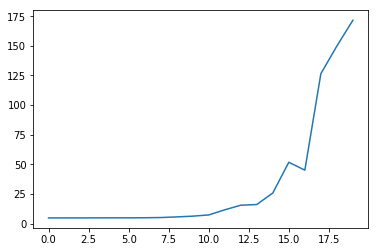

In [141]:
plt.plot(nn.losses)